In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import hiddenlayer as hl


# Any results you write to the current directory are saved as output.

In [2]:
from pathlib import Path
import unidecode
import unicodedata
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm_notebook,tqdm
import random
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,DataLoader,TensorDataset
from torch import optim
import time
import pdb
import gc
import re
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_df = pd.read_csv('../input/training/train_cleaned.csv')
inference_df = pd.read_csv('../input/abcdef/Cleaned_inference_data.csv').drop(['Company Name'], axis = 1)
inference_df = pd.DataFrame({"ids":range(inference_df.shape[0]), 'text': inference_df.values.tolist()}) 
inference_df.text = inference_df.text.astype('str')
inference_df.head(10)

,ids,text
0,0,['pharma provides healthcare products worldwid...
1,1,['flowers com together subsidiaries provides g...
2,2,['retech corporation subsidiaries operates int...
3,3,['property insurance holdings subsidiaries pro...
4,4,['holdings subsidiaries provides range product...
5,5,['western financial corporation subsidiaries o...
6,6,['mage software operates technology industry c...
7,7,['pm industries provides consulting services c...
8,8,['capital bank provides various banking produc...
9,9,['colonial bancorp operates bank holding compa...


In [4]:
dev_df = train_df
print(dev_df.shape, inference_df.shape)

(1970, 3) (8425, 2)


In [5]:
def seed_everything(seed=4823):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# Set hyperparams - 1

In [6]:
em_sz = 300
vocab_sz = 70000
max_len=250

In [7]:
tokenizer = Tokenizer(vocab_sz)
tokenizer.fit_on_texts(pd.concat([dev_df.text, inference_df.text]))

In [8]:
x_dev = tokenizer.texts_to_sequences(dev_df.text.values)
x_infr = tokenizer.texts_to_sequences(inference_df.text.values)
id_infr = inference_df.ids
tokenizer.word_index.update({"<eof>":len(tokenizer.word_index)+1})
print(len(tokenizer.word_index))

44853


In [9]:
x_dev = pad_sequences(x_dev, maxlen=max_len)
x_infr = pad_sequences(x_infr, maxlen=max_len)

In [10]:
y_dev = dev_df.label.values

In [11]:
print("x_dev:", x_dev.shape)
print("x_infr:", x_infr.shape)
print("y_train:", y_dev.shape)

x_dev: (1970, 250)
x_infr: (8425, 250)
y_train: (1970,)


# Load Embeddings

In [12]:
EMB_PATH = ('../input/gloveembedding/glove.6B.300d.txt')
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')


def load_glove(word_index):
    EMBEDDING_FILE = EMB_PATH
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]
    nb_words = min(vocab_sz, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= vocab_sz: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i:] = embedding_vector        
    return embedding_matrix 

In [13]:
seed_everything()
embed = None
em_fns = [load_glove]
#embed = np.mean([fn(tokenizer.word_index) for fn in em_fns],0)
embed = np.concatenate([fn(tokenizer.word_index) for fn in em_fns],1)
gc.collect()
embed.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(44853, 300)

# Splits for k-fold cross validation

In [14]:
splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=10).split(x_dev, y_dev))

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


# Define device

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Set hyperparams - 2

In [16]:
bs= 512 
num_epochs = 270
learning_rate = 0.001
num_classes = 196

# Define model architecture

In [17]:
class TextClassifierSimpleLSTM(nn.Module):
    def __init__(self,vocab_sz,emb_sz,hn=40):
        super().__init__()
        self.hn,self.vocab_sz,self.emb_sz = hn,vocab_sz,emb_sz
        self.emb = nn.Embedding(vocab_sz,emb_sz)
        self.emb.weight = nn.Parameter(torch.tensor(embed,dtype=torch.float32))
        self.emb.weight.requires_grad = False
        self.e_d = nn.Dropout2d(0.1)
        self.lstm = nn.LSTM(emb_sz, hn, bidirectional=True, batch_first=True)
        self.lstm_atn = Attention(hn * 2, max_len)
        self.fc = nn.Sequential(nn.Linear(240,16),nn.ReLU(),nn.Dropout(0.1),
                                nn.Linear(16,1))

    def forward(self,x):
        e_o = torch.squeeze(self.e_d(torch.unsqueeze(self.emb(x),0)))
        lstm_o,_ = self.lstm(e_o)
        lstm_atn = self.lstm_atn(lstm_o)
        concat_o = torch.cat([lstm_atn,torch.mean(lstm_o,1),torch.max(lstm_o,1)[0]],1)
        return self.fc(concat_o)
    
class TextClassifier(nn.Module):
    def __init__(self, vocab_sz, emb_sz, hn=60):
        super().__init__()
        self.hn, self.vocab_sz, self.emb_sz = hn,vocab_sz, emb_sz
        self.emb = nn.Embedding(vocab_sz, emb_sz)
        self.emb.weight = nn.Parameter(torch.tensor(embed, dtype=torch.float32))
        self.emb.weight.requires_grad = False
        self.e_d = nn.Dropout2d(0.1)
        self.lstm = nn.LSTM(emb_sz, hn, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hn*2, hn, batch_first=True, bidirectional=True)
        #self.lstm_atn = Attention(hn * 2, max_len)
        #self.gru_atn = Attention(hn * 2, max_len)
        self.fc = nn.Sequential(nn.Linear(hn*4, 16),nn.ReLU(),nn.Dropout(0.1),
                                nn.Linear(16, num_classes))

    def forward(self,x):
        #print("x:", x.shape)
        e_o = torch.squeeze(self.e_d(torch.unsqueeze(self.emb(x), 0)))
        #print("e_o:", e_o.shape)
        lstm_o,_ = self.lstm(e_o)
        #print("lstm_o:", lstm_o.shape)
        gru_o,_ = self.gru(lstm_o)
        #print("gru_o:", gru_o.shape)
        #lstm_atn = self.lstm_atn(lstm_o)
        #gru_atn = self.gru_atn(gru_o)
        concat_o = torch.cat([torch.mean(gru_o, 1),torch.max(gru_o, 1)[0]],1)
        #print("concat_o:", concat_o.shape)
        
        fc_out = self.fc(concat_o)
        #print("out:", fc_out.shape)
        return fc_out     

In [18]:
def sigmoid(x):return 1 / (1 + np.exp(-x))

In [19]:
model = TextClassifier(vocab_sz, embed.shape[1])
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
def onehot_encoder(batch_size, labels):
    onehot_encoded = np.zeros(shape=(batch_size, num_classes), dtype=np.int32)
    batch=0
    for label in labels:
        onehot_encoded[batch, label] = 1
        batch+=1
    return(onehot_encoded)

def save_model(model, pth):
    torch.save(model.state_dict(),pth)
    
def get_dl_split(split_id=0):
    trn_idxs,val_idxs = splits[split_id]
    trn_ds = TensorDataset(torch.tensor(x_dev[trn_idxs], dtype=torch.long), torch.tensor(y_dev[trn_idxs, np.newaxis], dtype=torch.float32))
    val_ds = TensorDataset(torch.tensor(x_dev[val_idxs], dtype=torch.long), torch.tensor(y_dev[val_idxs, np.newaxis], dtype=torch.float32))
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=bs*6, shuffle=False)
    return trn_dl, val_dl, y_dev[val_idxs], val_idxs

In [21]:
dev_ds = TensorDataset(torch.tensor(x_dev, dtype=torch.long), torch.tensor(y_dev, dtype=torch.float32))
dev_dl = DataLoader(dev_ds, batch_size=bs, shuffle=True)

infr_ds = TensorDataset(torch.tensor(x_infr, dtype=torch.long), torch.tensor(id_infr, dtype=torch.int32))
infr_dl = DataLoader(infr_ds, batch_size=1000, shuffle=False)

# Training with cross validation

In [ ]:

# A History object to store metrics
history = hl.History()
# A Canvas object to draw the metrics
canvas = hl.Canvas()
val_correct = val_total= correct = total = step = 0
# Begin Training
for fold_id in range(len(splits)):
    trn_dl, val_dl, y_val, val_idxs = get_dl_split(fold_id)
    for epoch in range(num_epochs):
        for text, label in trn_dl:
            text = text.to(device)
            label = label.squeeze().to(device, dtype=torch.int64)
            #print("text size:", text.shape)
            step += 1
            
            output = model(text)            
            loss = criterion(output, label)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predictions = torch.max(output.data, 1)
            correct += (predictions == label).sum(0).item()
            total += label.size(0)
            TrainAccuracy = correct / total
            
            history.log(step, loss=loss, accuracy=TrainAccuracy)
            # Plot the two metrics in one graph
            canvas.draw_plot([history['loss'], history['accuracy']])
             
            
        for text, label in val_dl:
            text = text.to(device)
            label = label.squeeze().to(device, dtype=torch.int64)
            
            val_output = model(text)
            val_loss = criterion(val_output, label)
            _, predictions = torch.max(val_output.data, 1)
            val_correct += (predictions == label).sum(0).item()
            val_total += label.size(0)
            ValAccuracy = val_correct / val_total
            
        print ('Epoch [{}/{}], Step [{}], Train_Loss: {:.4f}, Val_Loss: {:.4f}, TrainAccuracy: {:.4f}, ValAccuracy: {:.4f}'.format(epoch+1, num_epochs, step+1, loss.item(), val_loss.item(), TrainAccuracy, ValAccuracy))


# Train on the entire dev dataset

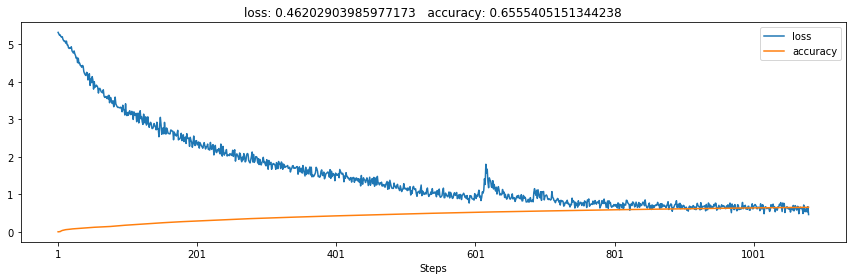

Epoch [270/270], Step [1081], Train_Loss: 0.4620, TrainAccuracy: 0.6555


In [22]:
# A History object to store metrics
history = hl.History()
# A Canvas object to draw the metrics
canvas = hl.Canvas()
# Begin Training
correct = total = step = 0
for epoch in range(num_epochs):
    for text, label in dev_dl:
        text = text.to(device)
        label = label.squeeze().to(device, dtype=torch.int64)
        step += 1
            
        output = model(text)            
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        _, predictions = torch.max(output.data, 1)
        correct += (predictions == label).sum(0).item()
        total += label.size(0)
        TrainAccuracy = correct / total
            
        history.log(step, loss=loss, accuracy=TrainAccuracy)
        # Plot the two metrics in one graph
        canvas.draw_plot([history['loss'], history['accuracy']])
        
        print ('Epoch [{}/{}], Step [{}], Train_Loss: {:.4f}, TrainAccuracy: {:.4f}'.format(epoch+1, num_epochs, step+1, loss.item(), TrainAccuracy))

In [23]:
# Save model
save_model(model, 'model2.ckpt')

# Inferencing

In [24]:
# Inferencing
pred_arr = []
id_arr = []
for text, ids in infr_dl:
    text = text.to(device)
    output = model(text)
    _, prediction = torch.max(output.data, 1)
    pred_arr.append(prediction)
    id_arr.append(ids)
    
prediction = torch.cat(pred_arr, dim=0)
ids = torch.cat(id_arr, dim=0)
print(ids.shape, prediction.shape)

torch.Size([8425]) torch.Size([8425])


# Save results

In [68]:
pred_df = pd.DataFrame({"ids":ids, "text":inference_df.text, "label":prediction})
out = train_df.drop(['text'], axis=1)
output = pd.merge(pred_df, out, on='label', how='left', sort=False).drop_duplicates()
output.head()

,ids,text,label,lable_text
0,0,['pharma provides healthcare products worldwid...,60,beautycareproducts
10,1,['flowers com together subsidiaries provides g...,58,banks
252,2,['retech corporation subsidiaries operates int...,184,informationtechnology
358,3,['property insurance holdings subsidiaries pro...,93,casualty
363,4,['holdings subsidiaries provides range product...,120,commercialandprofessionalservices


In [ ]:
output.to_csv('output3.csv')